In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
crypto_prices_df = pd.read_csv('chasewillden-cryptocurrency-price-by-date-2013-february-2018/chasewillden-cryptocurrency-price-by-date-2013-february-2018/data/cryptocurrency_prices_by_date.csv')

# Extract prices for the timeframe 01/01/2015 - 12/31/2018
# 2015-01-01 00:00:00  => 1420070400000
# 2018-12-31 23:59:59 => 1546261199000
crypto_prices_df = crypto_prices_df[(crypto_prices_df['date'] >= 1420070400000) & (crypto_prices_df['date'] <= 1546261199000)]

#print(crypto_prices_df.keys())

# Convert Unix time to Date time
crypto_prices_df['date'] = pd.to_datetime(crypto_prices_df['date'], unit='ms')
## prices.drop_duplicates('currency', keep='last')
## print(prices['currency'].unique())
crypto_prices_df['Year'] = crypto_prices_df['date'].dt.year
crypto_prices_df['Month'] = crypto_prices_df['date'].dt.month
crypto_prices_df['YearMonth'] = crypto_prices_df['date'].dt.to_period('m')
crypto_prices_df[(crypto_prices_df['currency'] == 'bitcoin')].head(20)

,currency,date,price,Year,Month,YearMonth
64769,bitcoin,2015-01-01 02:40:00,317.848,2015,1,2015-01
64770,bitcoin,2015-01-02 00:53:20,313.639,2015,1,2015-01
64771,bitcoin,2015-01-03 01:53:20,314.870,2015,1,2015-01
64772,bitcoin,2015-01-04 00:06:40,281.246,2015,1,2015-01
64773,bitcoin,2015-01-05 01:06:40,266.723,2015,1,2015-01
64774,bitcoin,2015-01-06 02:06:40,274.168,2015,1,2015-01
64775,bitcoin,2015-01-07 00:20:00,283.238,2015,1,2015-01
64776,bitcoin,2015-01-08 01:20:00,293.754,2015,1,2015-01
64777,bitcoin,2015-01-09 02:20:00,282.507,2015,1,2015-01
64778,bitcoin,2015-01-10 08:53:20,277.861,2015,1,2015-01


In [3]:
popular_cryptos = ['bitcoin','ethereum', 'tether', 'binance-coin', 'litecoin', 'dogecoin', 'cardano', 'monero', 'ripple']

prices_of_popular_cryptos = crypto_prices_df[crypto_prices_df['currency'].isin(popular_cryptos)]

prices_of_popular_cryptos.drop_duplicates('currency', keep='last')


,currency,date,price,Year,Month,YearMonth
51064,binance-coin,2018-02-10 02:33:20,10.238900,2018,2,2018-02
65899,bitcoin,2018-02-10 02:33:20,9037.510000,2018,2,2018-02
119853,cardano,2018-02-10 02:33:20,0.457995,2018,2,2018-02
188877,dogecoin,2018-02-10 02:33:20,0.005225,2018,2,2018-02
220978,ethereum,2018-02-10 02:33:20,904.994000,2018,2,2018-02
353462,litecoin,2018-02-10 02:33:20,167.287000,2018,2,2018-02
385124,monero,2018-02-10 02:33:20,267.645000,2018,2,2018-02
499855,ripple,2018-02-10 02:33:20,1.061200,2018,2,2018-02
578575,tether,2018-02-10 02:33:20,1.005510,2018,2,2018-02


In [4]:
# ax = sns.lineplot(data=crypto_prices_df[crypto_prices_df['currency'] == 'bitcoin'], x="date", y="price")

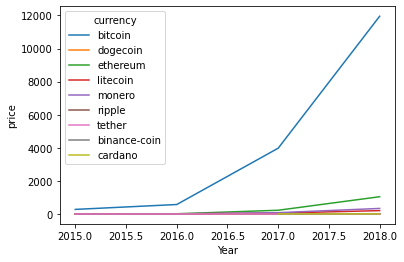

In [5]:
monthly_avg_prices = crypto_prices_df[crypto_prices_df['currency'].isin(popular_cryptos)].groupby(
    ["Year","currency"],as_index=True).mean().reset_index()
monthly_avg_prices

ax = sns.lineplot(data=monthly_avg_prices, x='Year', y='price',hue='currency')
# ax.set_yscale("log")
# ax = sns.lineplot(data=monthly_avg_prices[monthly_avg_prices['currency']=='bitcoin'], x='YearMonth', y='price',hue='currency')
# ax.set_xticks(ax.get_xticks().tolist())
# ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
# ax.set_xticklabels([pd.to_datetime(dateTime, unit='s').strftime('%Y-%m-%d\n %H:%M:%S') for dateTime in xticks],rotation=30)
# print(ax.get_xticks())


In [11]:
news = pd.read_json('cryptodata/news.json')
reddit = pd.read_json('cryptodata/reddit.json')
bitcointalk = pd.read_json('cryptodata/bitcointalk.json')

In [18]:
news = news[(news['date'].dt.year >= 2015) & (news['date'].dt.year <= 2018)]
reddit = reddit[(reddit['date'].dt.year >= 2015) & (reddit['date'].dt.year <= 2018)]
bitcoinTalk = bitcoinTalk[(bitcoinTalk['date'].dt.year >= 2015) & (bitcoinTalk['date'].dt.year <= 2018)]

print(len(news))
print(len(reddit))
print(len(bitcointalk))

#reddit.head(5)
#bitcointalk.head(5)
news.head(5)

63252
2752380
1664843


,text,post_id,date
9698,Venture capitalist Lou Kerner says bitcoin is ...,9783,2018-12-31 23:37:58
9699,"Charlie Lee, the creator of Litecoin and the m...",9784,2018-12-31 23:30:27
9700,As crypto’s value has dropped across the board...,9785,2018-12-31 23:24:38
9701,Hacks and heists have been a threat for as lon...,9786,2018-12-31 23:05:03
9702,It’s been over a year ...,9787,2018-12-31 22:46:45
